In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df


path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [2]:
def compute_calibration_ward_chunks(ward_chunk_pos, obs_chunk_pos_df, resample="W-Sun"):
    dates                  = pd.date_range(start=pd.to_datetime("2020-02-01"), periods=ward_chunk_pos.shape[0])
    dates_study            = pd.date_range(start=pd.to_datetime("2020-02-09"), end=pd.to_datetime("2021-02-28"), freq=resample)

    num_ensembles          = ward_chunk_pos.shape[-1]
    num_chunks             = ward_chunk_pos.shape[-2]

    df_ward_sims           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    df_ward_sims["date"]   = flatten_list([ [date]*num_ensembles for date in  list(dates)])
    df_ward_sims["id_ens"] = list(range(num_ensembles)) * len(dates)

    for ward_idx in range(num_chunks):
        ward_pos                        = ward_chunk_pos[:,ward_idx,:]
        df_ward_sims[f"pos_{ward_idx}"] = ward_pos.flatten()

    df_ward_sims = df_ward_sims.set_index(["date", "id_ens"]).unstack([1]).resample(resample).sum().stack().reset_index()#.set_index("date").reset_index()
    df_ward_sims = df_ward_sims[df_ward_sims.date.isin(dates_study)]

    obs_chunk_pos_df["date"] = pd.to_datetime(obs_chunk_pos_df["date"])
    obs_df                   = obs_chunk_pos_df[obs_chunk_pos_df.date.isin(dates_study)]
    obs_df                   = obs_df.set_index("date")
    obs_df                   = obs_df.reindex(dates_study, fill_value=0).reset_index()

    confidence_use = [25/100, 55/100, 75/100, 90/100]

    calibration_df = []
    for cluster_id in range(num_chunks):

        cal_df               = pd.DataFrame(columns=["confidence", "proportion_inside"])
        cal_df["confidence"] = confidence_use
        cal_df               = cal_df.set_index("confidence")

        for confidence in cal_df.index.values:
            chunk_cluster                  = ward_chunk_pos[:,cluster_id,:]
            df_ward                        = pd.DataFrame(chunk_cluster)
            df_ward["date"]                = dates
            df_ward                        = df_ward.set_index("date").resample(resample).sum().reset_index()
            df_ward                        = df_ward[df_ward.date.isin(dates_study)].set_index("date")
            df_resume                      = df_ward.T.quantile(q=[1-confidence, confidence]).T
            df_resume["obs"]               = obs_df[f"pos_{cluster_id}"].values
            df_resume["calibration"]       = df_resume.apply(lambda x: x[1-confidence] <= np.double(x.obs) <= x[confidence], axis=1)

            cal_df.loc[confidence]         = df_resume["calibration"].sum()/len(df_resume)

        cal_df["cluster_id"] = cluster_id
        calibration_df.append(cal_df)

    calibration_df  = pd.concat(calibration_df)

    return calibration_df

In [8]:
import seaborn as sns

path_to_save_samples = os.path.join('..', "..", "results", "amro_inferences")
specimens_inference  = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                            "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]


posterior_df = []
for specimen in specimens_inference:
    #specimen         = specimens_inference[0]
    #path_to_save_pid = os.path.join(path_to_save_samples, "cluster_level_corrected", '_'.join( specimen.lower().split()) )
    path_to_save_pid = os.path.join(path_to_save_samples, '_'.join( specimen.lower().split()) )

    posterior        = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
    # Posterior in last iteration
    param_iter       = posterior["param_post_iter"][:,:,-1]

    p_df          = pd.DataFrame(columns=["gamma", "beta", "amro"])
    p_df["gamma"] = param_iter[0, :]
    p_df["beta"]  = param_iter[1, :]

    p_df["amro"]  = specimen
    posterior_df.append(p_df)
posterior_df = pd.concat(posterior_df, ignore_index=True)
posterior_df["amro"] = posterior_df["amro"].replace({"METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS": "MSSA",
                                                        "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS": "MRSA",
                                                        "ESCHERICHIA COLI": "E. COLI",
                                                        "STAPHYLOCOCCUS EPIDERMIDIS": "STAPH. EPIDERMIDIS"} )

def edit_amro_name(name):
    if name =="MSSA" or name=="MRSA":
        return name
    return " ".join(w.lower().capitalize() for w in name.split(" "))

posterior_df["amro"] = posterior_df["amro"].apply(edit_amro_name)


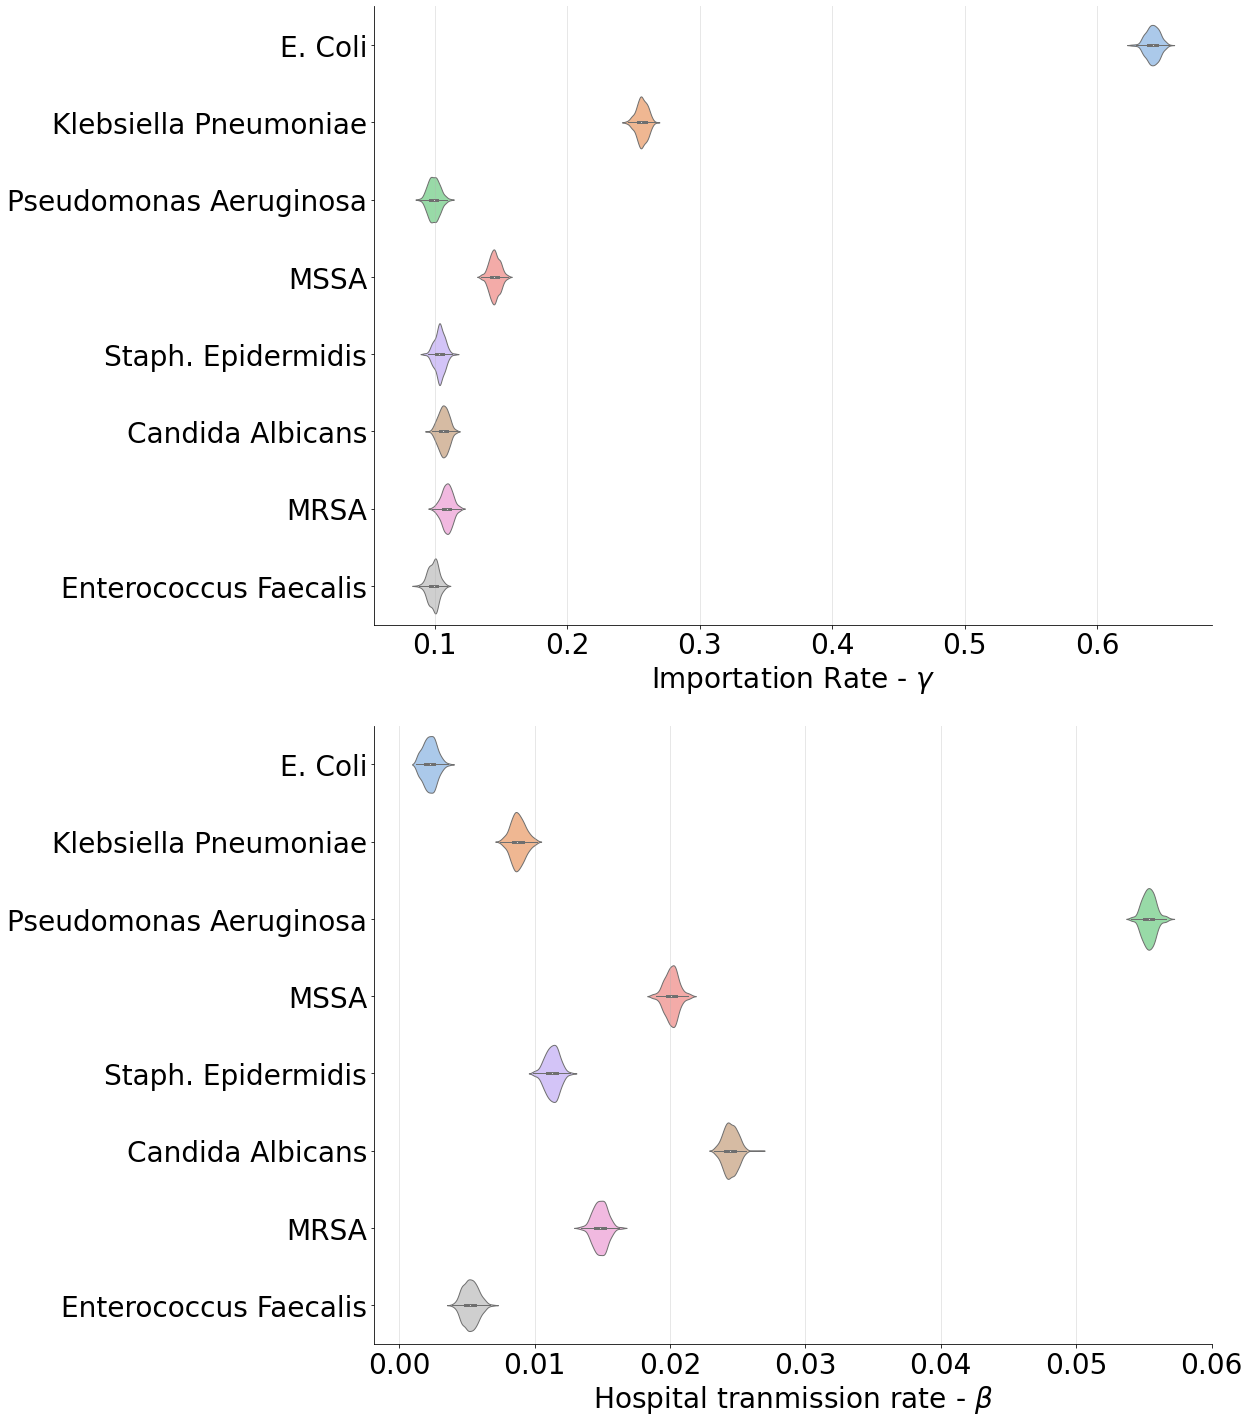

In [9]:

fig, ax = plt.subplots(2, 1, figsize=(18, 20.4), sharey=True)

sns.violinplot(ax=ax[0], data=posterior_df, x="gamma", y="amro", split=True,linewidth=1, palette=sns.color_palette("pastel",n_colors=len(specimens_inference)), alpha=0.7)
sns.violinplot(ax=ax[1], data=posterior_df, x="beta", y="amro", split=True, linewidth=1, palette=sns.color_palette("pastel",n_colors=len(specimens_inference)), alpha=0.7)
sns.despine(right=True, top=True)

ax[0].set_xlabel(r"Importation Rate - $\gamma$")
ax[1].set_xlabel(r"Hospital tranmission rate - $\beta$")

ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

ax[0].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)
ax[1].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)

plt.tight_layout()

In [17]:
abm_settings = {}
abm_settings['len_sim']      = 394
abm_settings['num_wards']    = 221
abm_settings['num_clusters'] = 6

In [19]:
from utils.infer_utils import create_df_response
from itertools import chain
pos_all_df = []
obs_all_df = []

def create_variable_df(dates, samples, variable_name, cluster=None):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = dates
    df["variable"] = [variable_name]*len(dates)
    if cluster:
        df["cluster"]=cluster
    return df

mle_df = []
obs_df = []

calibration_df = []
for specimen in specimens_inference:

    path_to_save_pid = os.path.join(path_to_save_samples, '_'.join( specimen.lower().split()) )
    sim_samples      = np.load(os.path.join(path_to_save_pid, 'mle_simulation.npz'))

    # Samples from MLE
    colonized_imported_mle  = np.maximum(sim_samples["ward_chunk_colonized_imported"].sum(1), 0);      colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=abm_settings['len_sim']).reset_index()
    colonized_mle           = np.maximum(sim_samples["ward_chunk_colonized"].sum(1)         , 0);     colonized_mle_df          = create_df_response(colonized_mle.T         , time=abm_settings['len_sim']).reset_index()
    positive_mle            = np.maximum(sim_samples["ward_chunk_positive"].sum(1)          , 0);      positive_mle_df           = create_df_response(positive_mle.T          , time=abm_settings['len_sim']).reset_index()
    negative_mle            = np.maximum(sim_samples["ward_chunk_negative"].sum(1)          , 0);      negative_mle_df           = create_df_response(negative_mle.T        , time=abm_settings['len_sim']).reset_index()
    nosocomial_mle          = colonized_mle-colonized_imported_mle;      nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=abm_settings['len_sim']).reset_index()

    ward_colonized_imp_mle        = np.maximum(sim_samples["ward_colonized_imported"], 0);       ward_colonized_imp_mle_df = pd.concat([create_df_response(ward_colonized_imp_mle[:,idx,:].T, time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_colonized_mle            = np.maximum(sim_samples["ward_colonized"], 0);                ward_colonized_mle_df     = pd.concat([create_df_response(ward_colonized_mle[:,idx,:].T,     time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_positive_mle             = np.maximum(sim_samples["ward_positive"], 0);                 ward_positive_mle_df      = pd.concat([create_df_response(ward_positive_mle[:,idx,:].T,      time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_negative_mle             = np.maximum(sim_samples["ward_negative"], 0);                 ward_negative_mle_df      = pd.concat([create_df_response(ward_negative_mle[:,idx,:].T,      time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_nosocomial_mle           = ward_colonized_mle-ward_colonized_imp_mle;                   ward_nosocomial_mle_df    = pd.concat([create_df_response(ward_nosocomial_mle[:,idx,:].T,    time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])

    ward_chunk_colonized_imp_mle  = np.maximum(sim_samples["ward_chunk_colonized_imported"], 0); ward_chunk_colonized_imp_mle_df = pd.concat([create_df_response(ward_chunk_colonized_imp_mle[:,idx_chunk,:].T, time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_colonized_mle      = np.maximum(sim_samples["ward_chunk_colonized"], 0);          ward_chunk_colonized_mle_df     = pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T,     time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_positive_mle       = np.maximum(sim_samples["ward_chunk_positive"], 0);           ward_chunk_positive_mle_df      = pd.concat([create_df_response(ward_chunk_positive_mle[:,idx_chunk,:].T,      time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_negative_mle       = np.maximum(sim_samples["ward_chunk_negative"], 0);           ward_chunk_negative_mle_df      = pd.concat([create_df_response(ward_chunk_negative_mle[:,idx_chunk,:].T,      time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_nosocomial_mle     = ward_chunk_colonized_mle-ward_chunk_colonized_imp_mle;       ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])

    # compute nosocomial from total colonizations and importations
    ward_chunk_colonized_imp_mle_df["cluster"] =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_nosocomial_mle_df["cluster"]    =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_colonized_mle_df["cluster"]     =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_positive_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_negative_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))

    ward_chunk_colonized_imp_mle_df["variable"] = "ward_chunk_imported"
    ward_chunk_nosocomial_mle_df["variable"]    = "ward_chunk_nosocomial"
    ward_chunk_colonized_mle_df["variable"]     = "ward_chunk_colonized"
    ward_chunk_positive_mle_df["variable"]      = "ward_chunk_positive"
    ward_chunk_negative_mle_df["variable"]      = "ward_chunk_negative"

    colonized_imported_mle_df["variable"]       = "imported"
    nosocomial_mle_df["variable"]               = "nosocomial"
    colonized_mle_df["variable"]                = "colonized"
    positive_mle_df["variable"]                 = "positive"
    negative_mle_df["variable"]                 = "negative"

    # concatenate mle results
    results_mle_df             = pd.concat([colonized_mle_df, colonized_imported_mle_df, nosocomial_mle_df, positive_mle_df, negative_mle_df, ward_chunk_colonized_mle_df, ward_chunk_colonized_imp_mle_df, ward_chunk_nosocomial_mle_df, ward_chunk_positive_mle_df, ward_chunk_negative_mle_df])
    results_mle_df["organism"] = specimen
    mle_df.append(results_mle_df)

    obs_org_df        = pd.read_csv(os.path.join(path_to_save_pid, "true_positives_obs.csv")); obs_org_df["organism"] = specimen
    ob_df             = pd.concat([create_variable_df(obs_org_df.date, obs_org_df[f"pos_{idx}"], variable_name="chunk_positive", cluster=idx+1) for idx in range(abm_settings["num_clusters"])])
    df_all            = create_variable_df(obs_org_df.date, obs_org_df[["pos_0", "pos_1", "pos_2", "pos_3", "pos_4", "pos_5"]].sum(1).values, variable_name="positive")
    ob_df             = pd.concat([ob_df, df_all])
    ob_df["organism"] = specimen

    obs_df.append(ob_df)

    cal_positive_df = compute_calibration_ward_chunks(ward_chunk_positive_mle, obs_org_df, resample="W-Sun");   cal_positive_df["variable"] = "positive";   cal_positive_df["organism"] = specimen
    calibration_df.extend([cal_positive_df])

calibration_df   = pd.concat(calibration_df).reset_index()
mle_df           = pd.concat(mle_df).reset_index(drop=True)
obs_df           = pd.concat(obs_df).reset_index(drop=True)

obs_w_df         = obs_df
obs_w_df["date"] = pd.to_datetime(obs_w_df["date"])
mle_w_df         = mle_df.set_index(["date", "variable", "cluster", "organism"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57398/541343761.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[5, 0].set_xticklabels(x_ticks_labels)


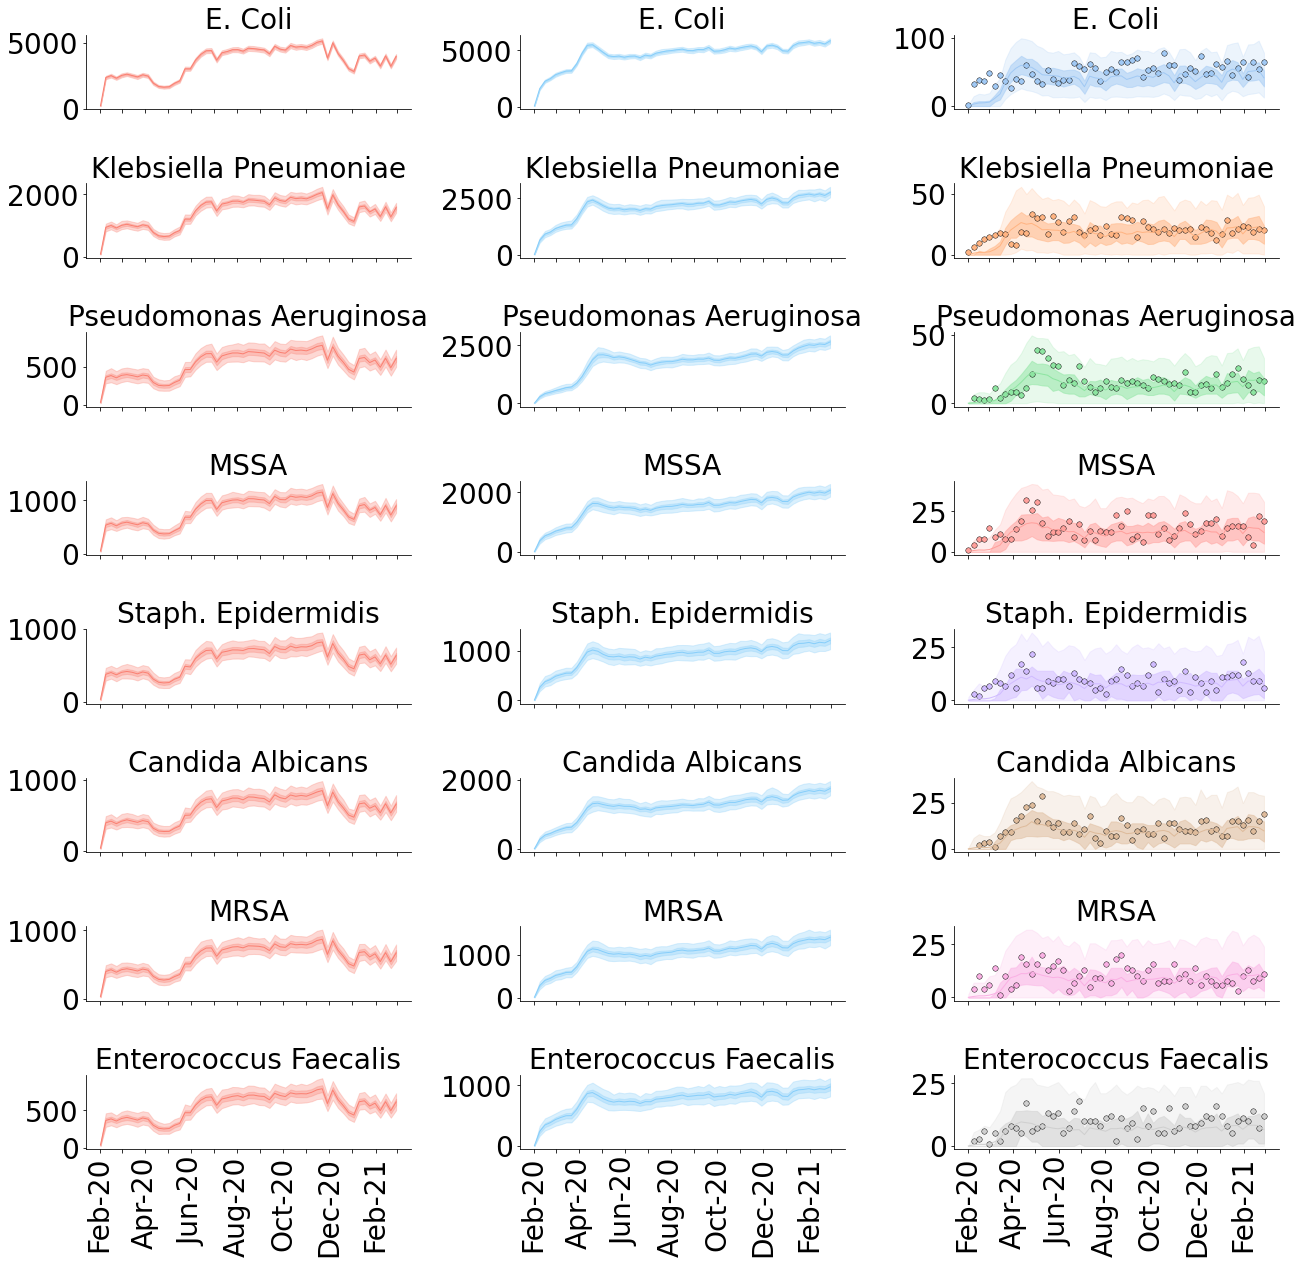

In [20]:
from utils.plot_utils import *

fig, ax     = plt.subplots(len(specimens_inference), 3, figsize=(18.5, 18.2), sharex=True)
dates_study = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun")

colors = sns.color_palette("pastel", n_colors=len(specimens_inference))
for idx_amro, amro in enumerate(specimens_inference):
    organism      = amro
    mle_var_df = mle_w_df[mle_w_df.variable=="imported"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]
    ax[idx_amro, 0].plot(mle_var_df["date"], mle_var_df["mean"], linewidth=1, color="salmon")
    ax[idx_amro, 0].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="salmon", alpha=0.3, label="Imported MLE")
    ax[idx_amro, 0].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="salmon", alpha=0.3)

    mle_var_df = mle_w_df[mle_w_df.variable=="nosocomial"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]

    ax[idx_amro, 1].plot(mle_var_df["date"], mle_var_df["mean"], linewidth=1, color="lightskyblue")
    ax[idx_amro, 1].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightskyblue", alpha=0.3, label="Nosocomial MLE")
    ax[idx_amro, 1].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightskyblue", alpha=0.3)

    var_df     = obs_w_df[obs_w_df.variable=="positive"]
    var_df     = var_df[var_df.date.isin(dates_study)]
    mle_var_df = mle_w_df[mle_w_df.variable=="positive"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]

    ax[idx_amro, 2].plot(mle_var_df["date"], mle_var_df["mean"], linewidth=1, color=colors[idx_amro])
    ax[idx_amro, 2].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color=colors[idx_amro], alpha=0.2)
    ax[idx_amro, 2].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color=colors[idx_amro], alpha=0.5)
    sns.scatterplot(ax=ax[idx_amro, 2], data=var_df[var_df.organism==organism], x="date", y="value", s=30, edgecolor="k", facecolor=colors[idx_amro], label="Simulated Colonizations")

    ylabel = pd.DataFrame([organism])
    ylabel = ylabel.replace( {"METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS": "MSSA",
                                                        "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS": "MRSA",
                                                        "ESCHERICHIA COLI": "E. COLI",
                                                        "STAPHYLOCOCCUS EPIDERMIDIS": "STAPH. EPIDERMIDIS"})
    ylabel = ylabel.values[0][0]
    ylabel = edit_amro_name(ylabel)
    ax[idx_amro, 0].set_title(ylabel, rotation=0)
    ax[idx_amro, 2].set_title(ylabel, rotation=0)
    ax[idx_amro, 1].set_title(ylabel, rotation=0)

for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend().remove()
        None

#sx_ticks_pos    = (18293.0, 0, 18322.0, 0,18353.0, 0,18383.0, 0,18414.0, 0,18444.0, 0,18475.0, 0,18506.0, 0,18536.0, 0,18567.0, 0,18597.0, 0,18628.0, 0,18659.0, 0,18687.0)
x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[5, 0].set_xticklabels(x_ticks_labels)
plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "fit_to_amro_obs.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


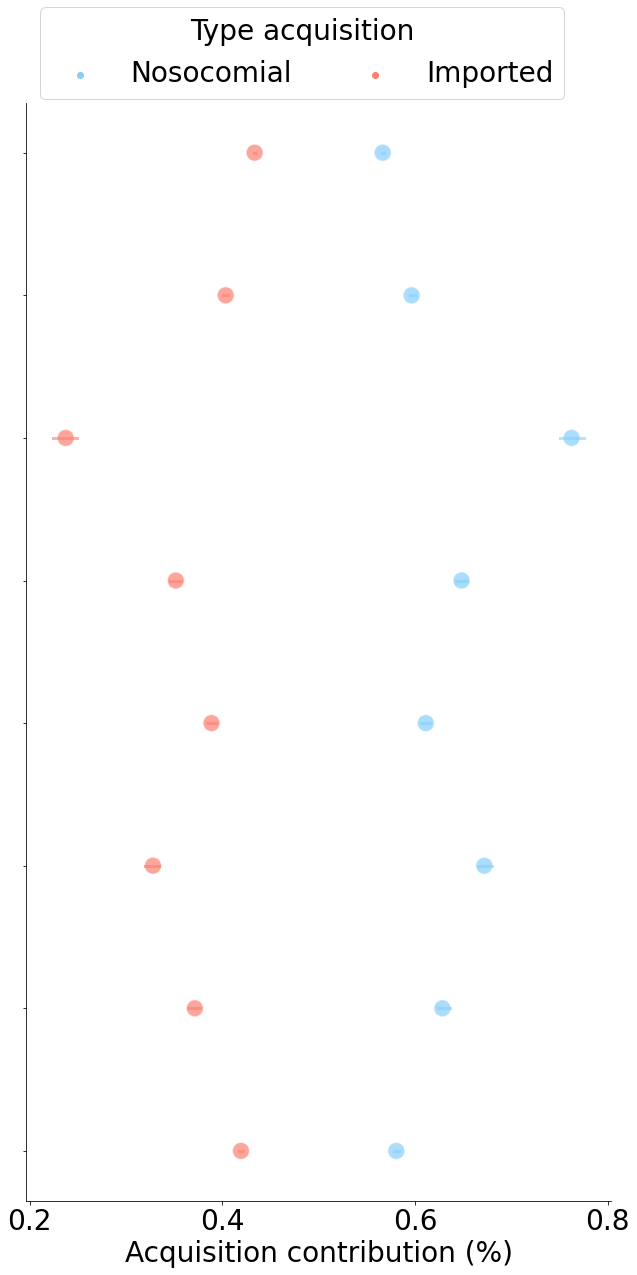

In [21]:
bar_df = []
for organism in specimens_inference:
    mle_var_df   = mle_w_df[mle_w_df.variable=="nosocomial"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]
    mle_var_df   = mle_var_df.set_index(["date", "organism", "variable"])
    bar_nosoc_df = mle_var_df.cumsum().reset_index().iloc[-1]


    mle_var_df = mle_w_df[mle_w_df.variable=="imported"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]
    mle_var_df = mle_var_df.set_index(["date", "organism", "variable"])
    bar_imp_df = mle_var_df.cumsum().reset_index().iloc[-1]

    df = pd.concat([pd.DataFrame(bar_nosoc_df).T, pd.DataFrame(bar_imp_df).T])
    df["mean_norm"] = df["mean"]/(bar_imp_df["mean"]+bar_nosoc_df["mean"])

    df["high_95_norm"] = df["high_95"]/(bar_imp_df["high_95"]+bar_nosoc_df["high_95"])
    df["low_95_norm"] = df["low_95"]/(bar_imp_df["low_95"]+bar_nosoc_df["low_95"])

    df["high_50_norm"] = df["high_50"]/(bar_imp_df["high_50"]+bar_nosoc_df["high_50"])
    df["low_50_norm"] = df["low_50"]/(bar_imp_df["low_50"]+bar_nosoc_df["low_50"])

    bar_df.append(df)

bar_df = pd.concat(bar_df)

bar_df["organism"] = bar_df["organism"].replace( {"METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS": "MSSA",
                                                    "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS": "MRSA",
                                                    "ESCHERICHIA COLI": "E. COLI",
                                                    "STAPHYLOCOCCUS EPIDERMIDIS": "STAPH. EPIDERMIDIS"})
bar_df["organism"] = bar_df["organism"].apply(lambda x: edit_amro_name(x))
bar_df["variable"] = bar_df["variable"].apply(lambda x: " ".join(x.split("_")) )
bar_df["variable"] = bar_df["variable"].apply(lambda x: edit_amro_name(x))

fig, ax = plt.subplots(1, 1, figsize=(9.5, 18.2))
g = sns.scatterplot(ax=ax, data=bar_df,  x="mean_norm", y="organism", hue="variable", palette=["lightskyblue", "salmon"], edgecolor="w", alpha=0.7, lw=1, s=300)
ax.legend(title="Type acquisition", bbox_to_anchor=(0.0, 1.1), ncol=2, loc="upper left")

g.set(yticklabels=[])

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

var2color = {"Nosocomial": "lightskyblue", "Imported": "salmon"}

for idx in range(len(specimens_inference*2)):
    xx  = [bar_df.low_95_norm.iloc[idx], bar_df.high_95_norm.iloc[idx]]
    var = bar_df.variable.iloc[idx]
    #ax.scatter(xx, [y_coords[idx], y_coords[idx]], lw=2, alpha=0.7, color=var2color[var], marker="|")
    ax.plot(xx, [y_coords[idx], y_coords[idx]], lw=3, alpha=0.6, color=var2color[var])

ax.set_xlabel("Acquisition contribution (%)")
sns.despine(right=True, top=True)
ax.set_ylabel(None)
plt.tight_layout()
#path_to_save  = os.path.join(path_to_ms_figs, "ScatterTypeAcquisition.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57398/4156136573.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57398/4156136573.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


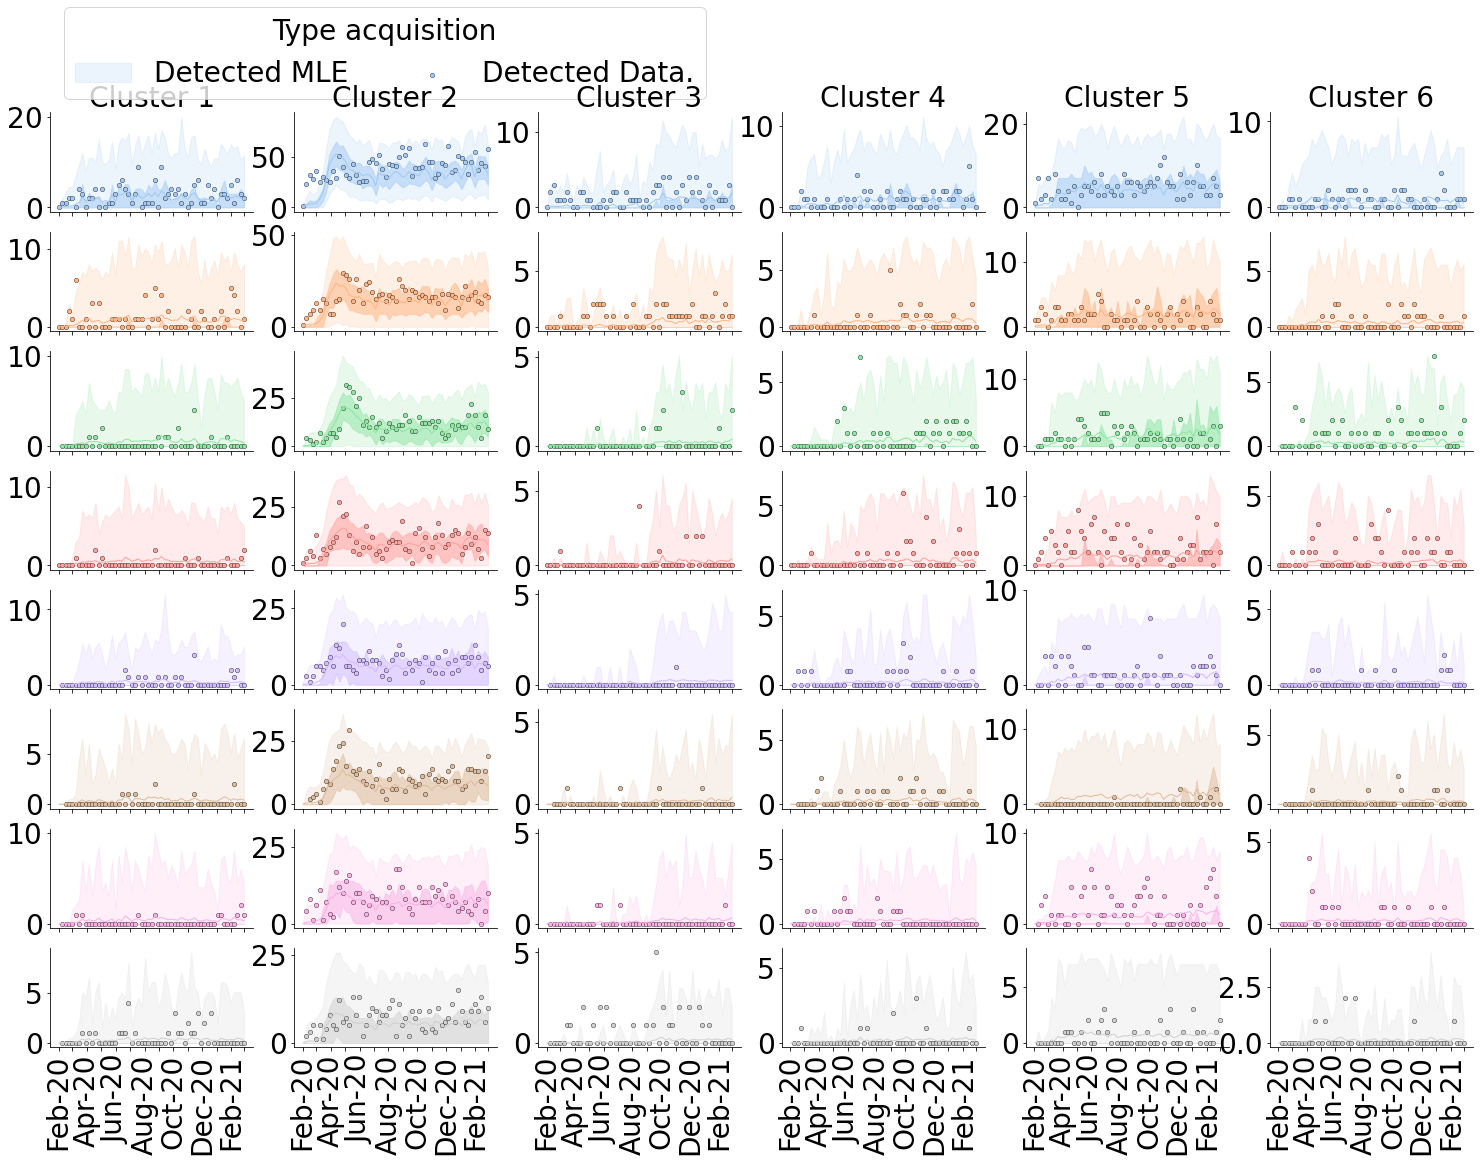

In [24]:

colors = sns.color_palette("pastel", n_colors=len(specimens_inference))

fig, ax = plt.subplots(len(specimens_inference), abm_settings["num_clusters"], figsize=(25.5, 17.2), sharex=True)
for idx_chunk in range(abm_settings["num_clusters"]):
    for idx_sce in range(len(specimens_inference)):

        var_df     = obs_w_df[obs_w_df.variable=="chunk_positive"]
        var_df     = var_df[var_df.organism==specimens_inference[idx_sce]]
        var_df     = var_df[var_df.cluster==idx_chunk+1]
        var_df     = var_df[var_df.date.isin(dates_study)]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
        mle_var_df = mle_var_df[mle_var_df.organism==specimens_inference[idx_sce]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df[mle_var_df.organism==specimens_inference[idx_sce]], x="date", y="mean", linewidth=1, color=colors[idx_sce])
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color=colors[idx_sce], alpha=0.2, label="Detected MLE")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color=colors[idx_sce], alpha=0.5)

        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df[var_df.organism==specimens_inference[idx_sce]], x="date", y="value", s=20, edgecolor="k", facecolor=colors[idx_sce], label="Detected Data.")


for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend(title="Type acquisition", bbox_to_anchor=(0.0, 2.2), ncol=2, loc="upper left")

x_ticks_pos    = (18293.0, 0, 18322.0, 0,18353.0, 0,18383.0, 0,18414.0, 0,18444.0, 0,18475.0, 0,18506.0, 0,18536.0, 0,18567.0, 0,18597.0, 0,18628.0, 0,18659.0, 0,18687.0)
x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

for idx_chunk in range(abm_settings["num_clusters"]):
    ax[0, idx_chunk].set_title(f"Cluster {idx_chunk+1}")

#for idx_sce in range(len(specimens_inference)):
#    ax[idx_sce, 0].set_ylabel(f"Scenario {idx_sce+1}", rotation=90)

plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "synthetic_fit_cluster_level.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


In [30]:

identity    = np.arange(0, 1, 0.01)
cal_this_df = calibration_df[calibration_df.variable=="positive"]
fig, ax     = plt.subplots(len(specimens_inference), 2, figsize=(15.5, 20.2), sharex="col")

for idx_organism in range(len(specimens_inference)):

    cal_plt_df    = cal_this_df[cal_this_df.organism==specimens_inference[idx_organism]]

    sns.lineplot(ax=ax[idx_organism, 1], data=cal_plt_df[cal_plt_df.cluster_id==1], x="confidence", y="proportion_inside", marker="o", lw=5, ms=10, mfc="w", mec="k", color="salmon")
    ax[idx_organism, 1].plot(identity, identity, color="k", linestyle="--", lw=3, label="y=x")
    ax[idx_organism, 1].set_xlabel("Predicted CI")
    ax[idx_organism, 1].set_ylabel("Observed")
    ax[idx_organism, 1].legend().remove()

    var_df     = obs_w_df[obs_w_df.variable=="chunk_positive"]
    var_df     = var_df[var_df.organism==specimens_inference[idx_organism]]
    var_df     = var_df[var_df.cluster==2]
    var_df     = var_df[var_df.date.isin(dates_study)]

    mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
    mle_var_df = mle_var_df[mle_var_df.organism==specimens_inference[idx_organism]]
    mle_var_df = mle_var_df[mle_var_df.cluster==2]

    sns.lineplot(ax=ax[idx_organism, 0], data=mle_var_df[mle_var_df.organism==specimens_inference[idx_organism]], x="date", y="mean", linewidth=1, color=colors[idx_organism])
    ax[idx_organism, 0].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color=colors[idx_organism], alpha=0.2, label="Detected Sim.")
    ax[idx_organism, 0].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color=colors[idx_organism], alpha=0.5)
    sns.scatterplot(ax=ax[idx_organism, 0], data=var_df[var_df.organism==specimens_inference[idx_organism]], x="date", y="value", s=15, edgecolor="k", facecolor=colors[idx_organism], label="Detected Data.")

    format_axis(ax[idx_organism, 0], week=False)

    ylabel = pd.DataFrame([specimens_inference[idx_organism]])
    ylabel = ylabel.replace( {"METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS": "MSSA",
                                                        "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS": "MRSA",
                                                        "ESCHERICHIA COLI": "E. COLI",
                                                        "STAPHYLOCOCCUS EPIDERMIDIS": "STAPH. EPIDERMIDIS"})
    ylabel = ylabel.values[0][0]
    ylabel = edit_amro_name(ylabel)

    ax[idx_organism, 0].set_title(ylabel, rotation=0)
    ax[idx_organism, 0].set_ylabel(None)
    ax[idx_organism, 0].set_xlabel(None)

    if idx_organism>0:
        ax[idx_organism, 0].legend().remove()
    else:
        ax[idx_organism, 0].legend(bbox_to_anchor=(-0.1, 2.6), ncol=1, loc="upper left")

x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

#plt.tight_layout()
fig.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.9, wspace=0.5, hspace=0.7)
#path_to_save  = os.path.join(path_to_ms_figs, "observations_calibration_plot.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)

